In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn import preprocessing
from google.colab import drive
from sklearn.model_selection import train_test_split
from IPython.core.display import Latex
import random
from sklearn.linear_model import LinearRegression
from time import sleep
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

##Statistical Analysis

In [ ]:
df = pd.read_csv('forestfires.csv')


In [ ]:
df.corr()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
X,1.000000,0.539548,-0.065003,-0.024922,-0.021039,-0.048384,-0.085916,0.006210,-0.051258,0.085223,0.018798,0.065387,0.063385
Y,0.539548,1.000000,-0.066292,-0.005453,-0.046308,0.007782,-0.101178,-0.024488,-0.024103,0.062221,-0.020341,0.033234,0.044873
month,-0.065003,-0.066292,1.000000,-0.050837,0.291477,0.466645,0.868698,0.186597,0.368842,-0.095280,-0.086368,0.013438,0.056496
day,-0.024922,-0.005453,-0.050837,1.000000,-0.041068,0.062870,0.000105,0.032909,0.052190,0.092151,0.032478,-0.048340,0.023226
FFMC,-0.021039,-0.046308,0.291477,-0.041068,1.000000,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.028485,0.056702,0.040122
DMC,-0.048384,0.007782,0.466645,0.062870,0.382619,1.000000,0.682192,0.305128,0.469594,0.073795,-0.105342,0.074790,0.072994
DC,-0.085916,-0.101178,0.868698,0.000105,0.330512,0.682192,1.000000,0.229154,0.496208,-0.039192,-0.203466,0.035861,0.049383
ISI,0.006210,-0.024488,0.186597,0.032909,0.531805,0.305128,0.229154,1.000000,0.394287,-0.132517,0.106826,0.067668,0.008258
temp,-0.051258,-0.024103,0.368842,0.052190,0.431532,0.469594,0.496208,0.394287,1.000000,-0.527390,-0.227116,0.069491,0.097844
RH,0.085223,0.062221,-0.095280,0.092151,-0.300995,0.073795,-0.039192,-0.132517,-0.527390,1.000000,0.069410,0.099751,-0.075519


Using this we can discard some of the variables due to their low correlation with the area.

In [ ]:
dataset = pd.read_csv('forestfires.csv')

x = (dataset[["X", "Y","month","day","FFMC","DMC","DC","ISI","temp","RH","wind","rain"]]).to_numpy()
y = (dataset[['area']]).to_numpy()

##Linear Regression functions

In [ ]:
#Función h (hipótesis), recibe una matriz x y un array w, retorna la hipótesis para cada característica
def h(x, w, b):
  ans = np.dot(x, w) + b
  return ans

#HUBER LOSS from: 
#https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3
#Función Error, recibe una matriz x, un array y, delta y una función que indica el tipo de error (MSE,MAE,HUB). Finalmente retorna el error.
def Error(x, y, w, b, delta=1.5, fun="MSE"):
  res = 0
  y_pred = h(x,w,b)
  num = np.shape(x)[0]
  if fun == "MSE":
    error = y - y_pred
    res = np.sum(error ** 2)/(2.0 * num)
  elif fun == "MAE":
    error = (y - y_pred)
    res = np.sum(np.abs(error))/(2.0 * num)
  elif fun == "HUB":
    error_mse = ((y - y_pred) ** 2)/(2.0 * num)
    error_mae = delta * (np.abs(y - y_pred) - 0.5 * delta)
    res = np.where(np.abs(y-y_pred) <= delta, error_mse, error_mae)
    res = np.sum(res)
  return res

# For the implementation of backpropagation formulas, we got them from:
# https://www.analyticsvidhya.com/blog/2019/08/detailed-guide-7-loss-functions-machine-learning-python-code/
#Función derivada, recibe una matriz x, un array y, delta y una función que indica el tipo de error (MSE,MAE,HUB). Finalmente retorna la derivada
def derivada(x, y, w, b, delta, fun = "MSE"):
  m = np.shape(x)[0]
  pred = h(x,w,b)
  error = y - pred 
  djb = b
  djw = w 
  if fun == "MSE":
    djw  = (1.0 / m) * -np.dot(x.T, error)
    djb  = (1.0 / m) * -np.sum(error)
  elif fun == "MAE":
    djw =  -np.dot(x.T , error / abs(error)) / m
    djb =  - np.sum(error / abs(error) ) / m
  elif fun ==  "HUB":
    # peso de mse + peso de mae
    djw  = np.where(error <= delta, -np.dot(x.T, error) ,  delta * -np.dot(x.T , error / abs(error)) )
    djb  = np.sum( np.where(error <= delta,  -error, -error / abs(-error)) )
  else:
    assert True, " Invalid Error function name given"

  return djb, djw
  
#Función update, recibe una matriz x, un array y, la penalización y un hiperparámetro alfa. Finalmente retorna w y el bias actualizado.
def update(w, b, dw, db, alfa):
    w = w - alfa * dw
    b = b - alfa * db 
    return b, w

In [ ]:
#Función split, splitea la data 
def split(x_q,y_q, q = 0.7):
  X_train, X_rest, y_train, y_rest = train_test_split(x_q, y_q , test_size=1-q, random_state=0)
  X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest , test_size=0.5, random_state=0)
  return X_train, y_train, X_test, y_test, X_val, y_val

#Función norm, normaliza la data
def norm(x,y,x_val,y_val,x_test, y_test):
  scaler_class_x = preprocessing.MinMaxScaler()
  scaler_class_y = preprocessing.MinMaxScaler()
  x_norm = scaler_class_x.fit_transform(x)
  y_norm = scaler_class_y.fit_transform(y)
  x_val_norm = scaler_class_x.transform(x_val)
  y_val_norm = scaler_class_y.transform(y_val)
  x_test_norm = scaler_class_x.transform(x_test)
  y_test_norm = scaler_class_y.transform(y_test)
  return x_norm , y_norm, x_val_norm, y_val_norm, x_test_norm, y_test_norm

#Función get_data
def get_data(X,Y,batch):
  N = Y.shape[0]
  val_lis = []
  x_batch_list=np.array([])
  y_batch_list=np.array([])
  random_list = random.sample(range(N), batch)
  x_batch_list = np.reshape(x_batch_list, (np.shape(x_batch_list)[0], np.shape(X)[1]))
  y_batch_list = np.reshape(y_batch_list, (np.shape(y_batch_list)[0], 1))
  for i in range(batch):
    x_batch_list = np.r_[x_batch_list, [X[random_list[i],:]]]
    y_batch_list = np.r_[y_batch_list, [Y[random_list[i],:]]] 
  return x_batch_list, y_batch_list

In [ ]:
#Función train, entrena el modelo dado.
def train(x, y, x_val, y_val, n_epochs, alfa, fun_type):
  np.random.seed(42)
  delta = 1.5

  m  = np.shape(x)[1:]
  w = np.random.randn(*m,1,)
  b = np.random.rand()
  loss = []
  loss_val = []
  current_fun  = fun_type
  for i in  tqdm(range(n_epochs), desc = f'Training with ({fun_type}) Progress Bar'):
    x_train, y_train = (x,y)
    if fun_type == "HUB":
      rand_idx = random.randint(0, np.shape(x)[0] - 1) 
      x_train = np.reshape( x[rand_idx] , (*m,1) ).T
      y_train = y[rand_idx].reshape(1,1)
      current_fun = "MSE" if (y_train - h(x_train,w,b)  <= delta) else "MAE"

    db, dw = derivada(x_train, y_train, w, b, delta, current_fun)
    b, w = update(w, b, dw, db, alfa)
    L = Error(x_train, y_train, w, b, delta, fun= current_fun)
    L_val = Error(x_val, y_val, w, b, delta, fun= current_fun)
    loss.append(L)
    loss_val.append(L_val)
  return b, w, loss, loss_val

## Testing

In [ ]:
def Plot_Loss(epochs, loss, loss_val, name = "Loss plot"):
  plt.title(name)
  plt.plot(epochs, loss, loss_val)
  plt.legend(["Loss Train","Loss Validation"])
  plt.xlabel("Epochs")
  plt.ylabel("Error")

def Plot_fig(fig, epochs, loss, loss_val):
  plt.plot(epochs, loss, loss_val, figure=fig)


def DeterminationCoefficient (x, y, w, b):
  SSR =  np.sum((y- h(x,w,b))**2)
  SST =   np.sum((y-y.mean())**2)
  return 1 - (SSR/SST)

def tester(data, instructions, Score = True, fun = "MAE" ):
  x_train, y_train, x_val, y_val, x_test, y_test = data
  i = 0
  fig = plt.figure()
  plt.title(f"Loss plot with {fun}")
  plt.xlabel("Epochs")
  plt.ylabel("Error")
  lst_legend = []

  for instruction in  instructions:
    n_epoch, alpha, graphs = instruction
    b, w, loss, loss_val = train(x_train, y_train, x_val, y_val, n_epoch, alpha, fun)
    if(Score):
      y_pred = h(x_test, w, b)
      print(f'Mean square error with value: {mean_squared_error(y_test, y_pred)}')
      print(f'Coefficient of determination with value: {DeterminationCoefficient(x_test,y_test,w,b)}' )
      
    if(graphs):
      epochs  = [i for i in range(n_epoch)]
      # Plot_Loss(epochs, loss, loss_val, name = f"Loss Plot with {funct}")\
      Plot_fig(fig, epochs, loss, loss_val)
      lst_legend.append(f"Loss Training {alpha}")
      lst_legend.append(f"Loss Validation {alpha}")
  plt.legend(lst_legend)

In [ ]:
x_train, y_train, x_test, y_test, x_val, y_val = split(x,y)
x_norm, y_norm, x_val_norm, y_val_norm, x_test_norm, y_test_norm  = norm(x_train,y_train, x_val, y_val, x_test, y_test)
data = (x_norm, y_norm, x_val_norm, y_val_norm, x_test_norm, y_val_norm)

Training with (MSE) Progress Bar: 100%|██████████| 1500/1500 [00:00<00:00, 9395.17it/s] 


Mean square error with value: 0.030522802200733157
Coefficient of determination with value: -0.06339784455024833


Training with (MSE) Progress Bar: 100%|██████████| 1500/1500 [00:00<00:00, 10975.98it/s]


Mean square error with value: 0.06722192611928317
Coefficient of determination with value: -1.341975381934124


Training with (MSE) Progress Bar: 100%|██████████| 1500/1500 [00:00<00:00, 9217.97it/s] 


Mean square error with value: 0.2431468966583789
Coefficient of determination with value: -7.471105769226897


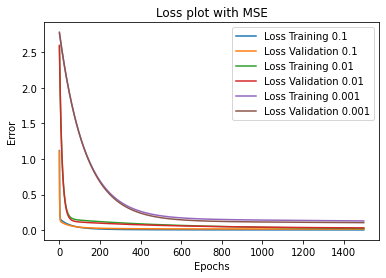

In [ ]:
n_epoch = 1500
fun = "MSE"
ins = [  
        (n_epoch, 0.1, True),
        (n_epoch, 0.01, True),
        (n_epoch, 0.001, True)
      ] 

tester(data, ins, fun  = fun)

In [ ]:
b, w, loss, loss_val = train(x_norm, y_norm, x_val_norm, y_val_norm, n_epoch, 0.1, "MSE")

y_pred = h(x_test_norm, w, b) 


print(f"\n RMSE of :{mean_squared_error(y_test, y_pred)}")

Training with (MSE) Progress Bar: 100%|██████████| 1500/1500 [00:00<00:00, 25927.58it/s]


 RMSE of :301.57360014804374


Training with (MAE) Progress Bar: 100%|██████████| 1500/1500 [00:00<00:00, 20822.98it/s]


Coefficient of determination with value: -2.106830182225445


Training with (MAE) Progress Bar: 100%|██████████| 1500/1500 [00:00<00:00, 23354.19it/s]


Coefficient of determination with value: -0.11271979450461078


Training with (MAE) Progress Bar: 100%|██████████| 1500/1500 [00:00<00:00, 22594.81it/s]


Coefficient of determination with value: -6.940661372057374


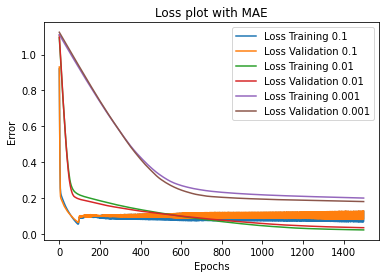

In [ ]:
fun = "MAE"
ins = [  
        # ("MSE", 15000, 0.001, False),
        (n_epoch, 0.1, True),
        (n_epoch, 0.01, True),
        (n_epoch, 0.001, True)
      ] 

tester(data, ins, fun  = fun)

Training with (HUB) Progress Bar: 100%|██████████| 1500/1500 [00:00<00:00, 17655.37it/s]


Coefficient of determination with value: -0.08426946899818355


Training with (HUB) Progress Bar: 100%|██████████| 1500/1500 [00:00<00:00, 20118.17it/s]


Coefficient of determination with value: -1.3172598386685666


Training with (HUB) Progress Bar: 100%|██████████| 1500/1500 [00:00<00:00, 16012.30it/s]


Coefficient of determination with value: -7.59941539006468


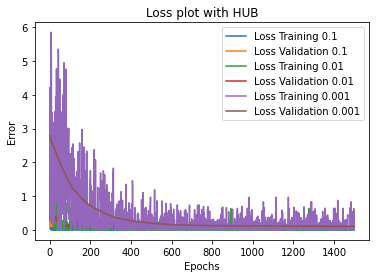

In [ ]:
fun = "HUB"
ins = [  
        # ("MSE", 15000, 0.001, False),
        (n_epoch, 0.1, True),
        (n_epoch, 0.01, True),
        (n_epoch, 0.001, True)
      ] 

tester(data, ins, fun  = fun)

In [ ]:

regression = LinearRegression()

model = regression.fit(x_train, y_train)
score = model.score(x_test, y_test)
y_pred = model.predict(x_test)
print(model.coef_)
print("The RMSE:",mean_squared_error(y_test, y_pred))
print("The R²:",r2_score(y_test, y_pred))

[[1.933 0.169 2.003 -0.870 -0.185 0.133 -0.035 -0.275 0.539 -0.155 0.771
  -2.647]]
The RMSE: 290.796246935457
The R²: -0.18871393034184036
